In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class GenericGRU(nn.Module):
    def __init__(self, H_no, E_no, I_no, sub_no, C_syn_e, C_syn_i, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        self.sub_no = sub_no
        self.C_syn_e = C_syn_e
        self.C_syn_i = C_syn_i
        self.E_no = E_no
        self.I_no = I_no
        
        self.E_scale = nn.Parameter(torch.zeros(self.E_no), requires_grad=True)
        self.I_scale = nn.Parameter(torch.zeros(self.I_no), requires_grad=True)
        
        self.rnn = nn.ModuleList()
        self.linear = nn.ModuleList()
        for s in range(self.sub_no):
            self.rnn.append(nn.GRU(1, self.H_no, batch_first=True))
            self.linear.append(nn.Linear(self.H_no, 1))
        
        
    def forward(self, S_e, S_i):
        T_data = S_e.shape[1]
        batch_size = S_e.shape[0]
        S_e = S_e * torch.exp(self.E_scale.reshape(1,1,-1))
        S_i = S_i * torch.exp(self.I_scale.reshape(1,1,-1))*(-1)
        
        S_e_sub = torch.matmul(S_e, self.C_syn_e.T.unsqueeze(0))
        S_i_sub = torch.matmul(S_i, self.C_syn_i.T.unsqueeze(0))
        S_sub = S_e_sub + S_i_sub
        
        sub_out = torch.zeros(batch_size, T_data, self.sub_no).to(self.device)
        
        for s in range(self.sub_no):
            rnn_out, _ = self.rnn[s](S_sub[:,:,s].unsqueeze(2))
            lin_out = self.linear[s](rnn_out.reshape(-1,self.H_no)).reshape(batch_size, T_data)
            sub_out[:,:,s] = sub_out[:,:,s] + lin_out     
        final = torch.sum(sub_out, 2)
        
        return final, sub_out


In [3]:
T_train = 648 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 20
layer_no = 1
sub_no = 6
E_no = 2000
I_no = 200
device = torch.device("cuda")

batch_length = 50000
batch_size = 6
iter_no = 9720
epoch_no = iter_no*batch_length*batch_size//T_train 

In [4]:
base_dir = "/media/hdd01/sklee/"
experiment = "rand"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

C_syn_e = np.load("/media/hdd01/sklee/CA1_rand/data/handsub6_C_syn_e.npy")
C_syn_i = np.load("/media/hdd01/sklee/CA1_rand/data/handsub6_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).to(device).float()
C_syn_i = torch.from_numpy(C_syn_i).to(device).float()

In [5]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = GenericGRU(H_no, E_no, I_no, sub_no, C_syn_e, C_syn_i, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5000, gamma=0.75)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

10606


In [ ]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _ = model(batch_E_neural, batch_I_neural)
    
    loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test-test_V_pred)**2).item()
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-7-cd04a2bf8411>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -0.020459 0.069405
49 0.003003 0.026784
99 0.004925 0.026655
149 0.007125 0.026589
199 0.016694 0.026333
249 0.043182 0.025702
299 0.05586 0.025327
349 0.071577 0.024863
399 0.07902 0.024702
449 0.090288 0.024502
499 0.100944 0.024081
549 0.105998 0.024043
599 0.108969 0.023918
649 0.096566 0.024205
699 0.126292 0.023567


In [9]:
#.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat.pt")

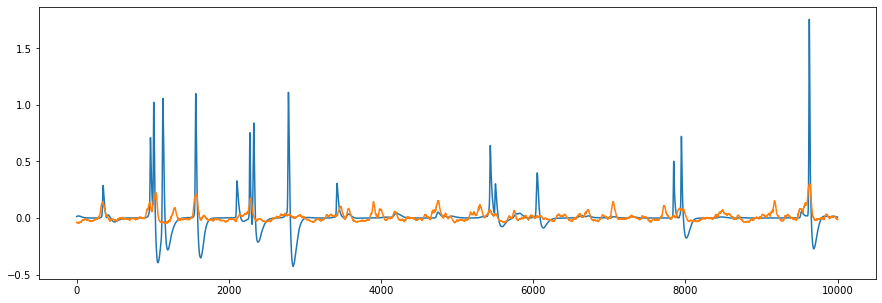

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[6000:16000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000])

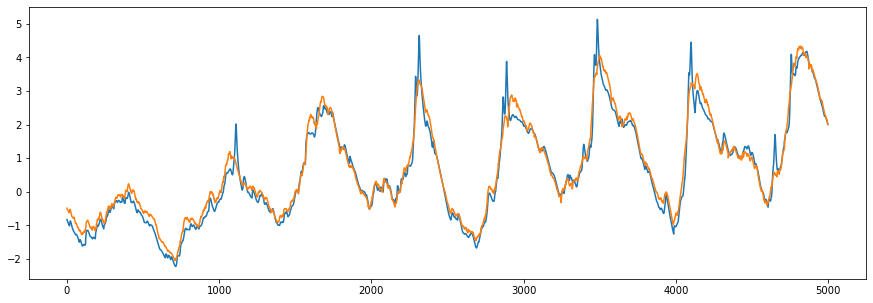

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[10000:40000][6000:16000][:5000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000][:5000])

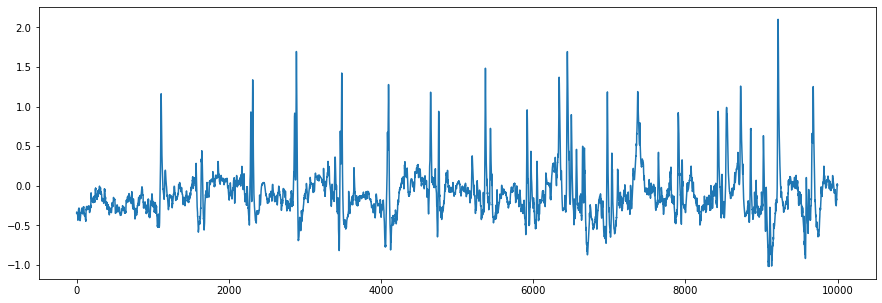

In [11]:
diff = V_test[10000:40000] - test_V_pred

plt.figure(figsize = (15,5))
plt.plot(diff.cpu().detach().numpy()[6000:16000])